In [8]:
import numpy as np
import pandas as pd

In [9]:
import pyodbc


In [37]:
server = 'localhost,1433'
database = 'Healthcare_database'
username = 'username'
password = '********'

connection_string = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}'


In [38]:
# Establish the connection
connection = pyodbc.connect(connection_string)



# Preparing Dataset

In [39]:
query = "select encounters.ENCOUNTERCLASS,encounters.CODE AS encounter_code,encounters.BASE_ENCOUNTER_COST,encounters.TOTAL_CLAIM_COST,conditions.CODE As condition_code,immunizations.BASE_COST As BASE_IMMUNE_COST, immunizations.CODE as IMMUNE_CODE,procedures.CODE AS Procedure_Code, procedures.BASE_COST AS BASE_Procedure_Cost from (((encounters full join conditions on encounters.Id=conditions.ENCOUNTER) full join immunizations on encounters.Id =immunizations.ENCOUNTER) full join procedures on encounters.Id=procedures.ENCOUNTER)"
df = pd.read_sql(query, connection)

# Display the DataFrame
print(df)

C:\Users\pavel\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


       ENCOUNTERCLASS  encounter_code  BASE_ENCOUNTER_COST  TOTAL_CLAIM_COST  \
0            wellness       410620009           129.160004        471.980011   
1          ambulatory       185345009            77.489998       2363.810059   
2            wellness       308646001           129.160004          0.000000   
3           inpatient       185347001            77.489998      10956.370117   
4           inpatient       185347001            77.489998      10956.370117   
...               ...             ...                  ...               ...   
177057     ambulatory       185345009            77.489998      14501.769531   
177058      inpatient       310061009           129.160004       3243.429932   
177059      inpatient       310061009           129.160004       3243.429932   
177060     urgentcare       702927004           129.160004        129.160004   
177061     outpatient       698314001           129.160004        129.160004   

       condition_code  BASE_IMMUNE_COST

In [40]:
df.head()

,ENCOUNTERCLASS,encounter_code,BASE_ENCOUNTER_COST,TOTAL_CLAIM_COST,condition_code,BASE_IMMUNE_COST,IMMUNE_CODE,Procedure_Code,BASE_Procedure_Cost
0,wellness,410620009,129.160004,471.980011,None,NaN,None,NaN,NaN
1,ambulatory,185345009,77.489998,2363.810059,43878008,NaN,None,117015009.0,2286.320068
2,wellness,308646001,129.160004,0.000000,None,NaN,None,NaN,NaN
3,inpatient,185347001,77.489998,10956.370117,None,NaN,None,398171003.0,516.650024
4,inpatient,185347001,77.489998,10956.370117,None,NaN,None,703423002.0,9845.580078


## Cleaning the Dataset

In [42]:
df.isnull().sum()

ENCOUNTERCLASS             0
encounter_code             0
BASE_ENCOUNTER_COST        0
TOTAL_CLAIM_COST           0
condition_code         51384
BASE_IMMUNE_COST       95280
IMMUNE_CODE            95280
Procedure_Code         42319
BASE_Procedure_Cost    42319
dtype: int64

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177062 entries, 0 to 177061
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ENCOUNTERCLASS       177062 non-null  object 
 1   encounter_code       177062 non-null  int64  
 2   BASE_ENCOUNTER_COST  177062 non-null  float64
 3   TOTAL_CLAIM_COST     177062 non-null  float64
 4   condition_code       125678 non-null  object 
 5   BASE_IMMUNE_COST     81782 non-null   float64
 6   IMMUNE_CODE          81782 non-null   object 
 7   Procedure_Code       134743 non-null  float64
 8   BASE_Procedure_Cost  134743 non-null  float64
dtypes: float64(5), int64(1), object(3)
memory usage: 12.2+ MB


In [44]:
df.describe()

,encounter_code,BASE_ENCOUNTER_COST,TOTAL_CLAIM_COST,BASE_IMMUNE_COST,Procedure_Code,BASE_Procedure_Cost
count,1.770620e+05,177062.000000,177062.000000,81782.000000,1.347430e+05,134743.000000
mean,2.312906e+08,116.931340,6823.643896,140.520004,1.282967e+14,1924.503270
std,1.270388e+08,21.961731,17376.536528,0.000000,8.778058e+14,5893.270851
min,1.505002e+06,77.489998,0.000000,140.520004,1.225002e+06,0.730000
25%,1.626730e+08,129.160004,678.479980,140.520004,2.251580e+08,516.650024
50%,1.626730e+08,129.160004,1135.810059,140.520004,7.108240e+08,516.650024
75%,3.083350e+08,129.160004,1776.910034,140.520004,7.633020e+08,516.650024
max,7.029270e+08,129.160004,873646.187500,140.520004,1.633503e+16,623242.000000


#### Filling null values with 0 because the code can be 0 if patient doesn't have any condition,immune or procedure code. Also simultaneously the Base cost will be 0 too.

In [45]:
columns_to_fill = ['condition_code','BASE_IMMUNE_COST','IMMUNE_CODE','Procedure_Code','BASE_Procedure_Cost']

In [46]:
df[columns_to_fill]=df[columns_to_fill].fillna(0)

In [47]:
df.isnull().sum()

ENCOUNTERCLASS         0
encounter_code         0
BASE_ENCOUNTER_COST    0
TOTAL_CLAIM_COST       0
condition_code         0
BASE_IMMUNE_COST       0
IMMUNE_CODE            0
Procedure_Code         0
BASE_Procedure_Cost    0
dtype: int64

## Modeling

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

In [49]:
X=df.drop(['ENCOUNTERCLASS','BASE_Procedure_Cost','BASE_ENCOUNTER_COST','BASE_IMMUNE_COST','TOTAL_CLAIM_COST'],axis=1)

In [50]:
y=df['ENCOUNTERCLASS']

In [51]:
X.head()

,encounter_code,condition_code,IMMUNE_CODE,Procedure_Code
0,410620009,0,0,0.0
1,185345009,43878008,0,117015009.0
2,308646001,0,0,0.0
3,185347001,0,0,398171003.0
4,185347001,0,0,703423002.0


In [52]:
y.head()

0      wellness
1    ambulatory
2      wellness
3     inpatient
4     inpatient
Name: ENCOUNTERCLASS, dtype: object

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

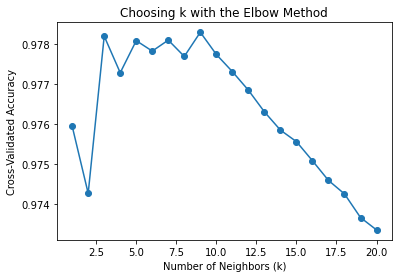

In [55]:
k_values = np.arange(1, 21)
accuracy_scores = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model, X_train, y_train, cv=5)  # 5-fold cross-validation
    accuracy_scores.append(np.mean(scores))

# Plot the results
plt.plot(k_values, accuracy_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Choosing k with the Elbow Method')
plt.show()

In [59]:
k = 6  # Choose the number of neighbors
model1 = KNeighborsClassifier(n_neighbors=k)
model1.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=6)

In [60]:
# Make predictions
y_pred = model1.predict(X_test)

In [61]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:\n', report)

Accuracy: 0.9787083839268066
Classification Report:
               precision    recall  f1-score   support

  ambulatory       0.95      0.97      0.96      8254
   emergency       0.97      0.99      0.98       691
   inpatient       0.96      0.93      0.94      1026
  outpatient       0.95      0.92      0.93      4944
  urgentcare       1.00      1.00      1.00       555
    wellness       1.00      1.00      1.00     19943

    accuracy                           0.98     35413
   macro avg       0.97      0.97      0.97     35413
weighted avg       0.98      0.98      0.98     35413

